# Introdução

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import nltk
import unicodedata
from IPython.display import display
import re
import string

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leona\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leona\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\leona\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# Carregando os dados de produtos

Vamos carregar apenas os dados de produto de treinamento para essa análise
exploratória.

In [3]:
df = pd.read_pickle("../data/train_prod.pickle").dropna().reset_index(drop=True)
df.head()

,product_id,seller_id,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,7204422,555670,Promoção Imperdível - Wrap Sling Canguru,wrap sling,2017-08-04 00:07:46,36.990000,2510.000000,1,3.0,303.0,43.0,Bebê
1,10163372,8613620,Bichos de Floresta Safári Selva,escultura bichos pelucias safari festa safari,2018-07-18 11:24:35,28.050000,107.000000,1,6.0,761.0,0.0,Lembrancinhas
2,1360356,6874394,Aparador Tripé Juncado com Moldura de Espelho,aparadores,2018-12-01 14:05:39,501.320000,8009.000000,1,9.0,363.0,0.0,Decoração
3,10037747,8861664,Fralda de boca,fraldinha boca comprar 1 fralda,2015-01-02 22:46:51,50.100000,5.000000,1,2.5,220.0,0.0,Bebê
4,558894,992102,Copo Twister com tmapa e canudo Personalizado ...,copo personalizado moana tartaruga produtos mi...,2017-02-11 17:35:01,11.466667,125.333333,1,22.0,317.0,16.0,Lembrancinhas


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20822 entries, 0 to 20821
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product_id         20822 non-null  int64         
 1   seller_id          20822 non-null  int64         
 2   title              20822 non-null  object        
 3   concatenated_tags  20822 non-null  object        
 4   creation_date      20822 non-null  datetime64[ns]
 5   price              20822 non-null  float64       
 6   weight             20822 non-null  float64       
 7   express_delivery   20822 non-null  int64         
 8   minimum_quantity   20822 non-null  float64       
 9   view_counts        20822 non-null  float64       
 10  order_counts       20822 non-null  float64       
 11  category           20822 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(3), object(3)
memory usage: 1.9+ MB


In [5]:
df.drop(columns=["product_id", "seller_id", "express_delivery"]).groupby("category").describe().T.round(2)

category                    Bebê  Bijuterias e Jóias  Decoração  \
price            count   3808.00              604.00    5168.00   
                 mean     142.97              181.57     156.89   
                 std      307.25              453.10     263.60   
                 min        0.35                2.99       0.45   
                 25%       42.48               40.28      46.14   
                 50%       93.22               89.15      80.07   
                 75%      172.84              169.90     169.25   
                 max    11509.38             6059.45    6289.37   
weight           count   3808.00              604.00    5168.00   
                 mean     349.33               49.09    1070.11   
                 std     1140.81              281.65    3469.66   
                 min        0.00                0.00       0.00   
                 25%        6.00                6.00       7.00   
                 50%        9.00                9.00     157.00   
                 75%      200.00               18.00     710.00   
                 max    27006.00             5810.00   65007.00   
minimum_quantity count   3808.00              604.00    5168.00   
                 mean       6.25                4.22       4.57   
                 std        7.89                4.73       5.45   
                 min        0.00                0.00       0.00   
                 25%        1.00                1.00       1.00   
                 50%        5.00                4.00       4.00   
                 75%        7.00                6.50       6.00   
                 max      106.00               57.00     122.50   
view_counts      count   3808.00              604.00    5168.00   
                 mean     480.26              510.14     367.24   
                 std     1181.33             1577.55    1085.26   
                 min        1.00                1.00       1.00   
                 25%      117.00               75.00      94.00   
                 50%      234.00              168.50     179.00   
                 75%      486.25              364.12     357.00   
                 max    34000.60            28530.00   45010.00   
order_counts     count   3808.00              604.00    5168.00   
                 mean      14.68               23.35       9.17   
                 std       36.20              105.20      32.94   
                 min        0.00                0.00       0.00   
                 25%        0.00                0.00       0.00   
                 50%        5.00               10.00       0.00   
                 75%       17.00               22.00      12.00   
                 max      788.60             2460.00    1586.00   

category                Lembrancinhas    Outros  Papel e Cia  
price            count        8931.00    708.00      1603.00  
                 mean           25.30     66.27        49.00  
                 std            45.21    161.51        75.03  
                 min             0.12      0.39         0.07  
                 25%            10.69     15.58        11.20  
                 50%            13.53     29.54        25.90  
                 75%            20.32     62.18        62.68  
                 max          1017.60   2998.71      1508.94  
weight           count        8931.00    708.00      1603.00  
                 mean           64.34    896.60       152.37  
                 std           288.38   5226.44       679.14  
                 min             0.00      0.00         0.00  
                 25%             6.00      7.00         6.00  
                 50%             8.00     12.00         8.00  
                 75%            28.00    190.25        33.33  
                 max         11006.00  60009.00     15007.00  
minimum_quantity count        8931.00    708.00      1603.00  
                 mean           20.99      6.69        32.08  
                 std            37.10     13.58       1

In [6]:
def get_sample_data(data, stratify, size):
    sample_data = pd.DataFrame(columns=data.columns)
    for cat in data[stratify].unique():
        cat_data = data[data[stratify] == cat]
        cat_sample = cat_data.sample(size)
        sample_data = pd.concat([sample_data, cat_sample])
    return sample_data

def remove_outliers(data, col):
    q25 = data[col].quantile(.25)
    q75 = data[col].quantile(.75)
    iqr = q75 - q25
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    outlier_mask = (data[col] < lower_bound) | (data[col] > upper_bound)
    return data[~outlier_mask]

def plot(data, col_list, stratify, size):
    data = data.reset_index(drop=True)
    for col in col_list:
        if col == stratify:
            continue
        data = remove_outliers(data, col)
    
    
    sample_data = get_sample_data(data, stratify=stratify, size=size)
    plt.figure(figsize=(20, 20))
    sns.pairplot(data=sample_data[col_list],
                 hue=stratify,
                 corner=True,
                 plot_kws={"alpha": 0.3})
    plt.show()

In [7]:
col_list = ["price_log", "weight_log", "minimum_quantity", 
            "view_counts", "order_counts", "category"]

df["price_log"] = np.log(df["price"])
df["weight_log"] = np.log(df["weight"])

C:\Users\leona\.virtualenvs\product_recommender-qoUF0oDD\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 1440x1440 with 0 Axes>

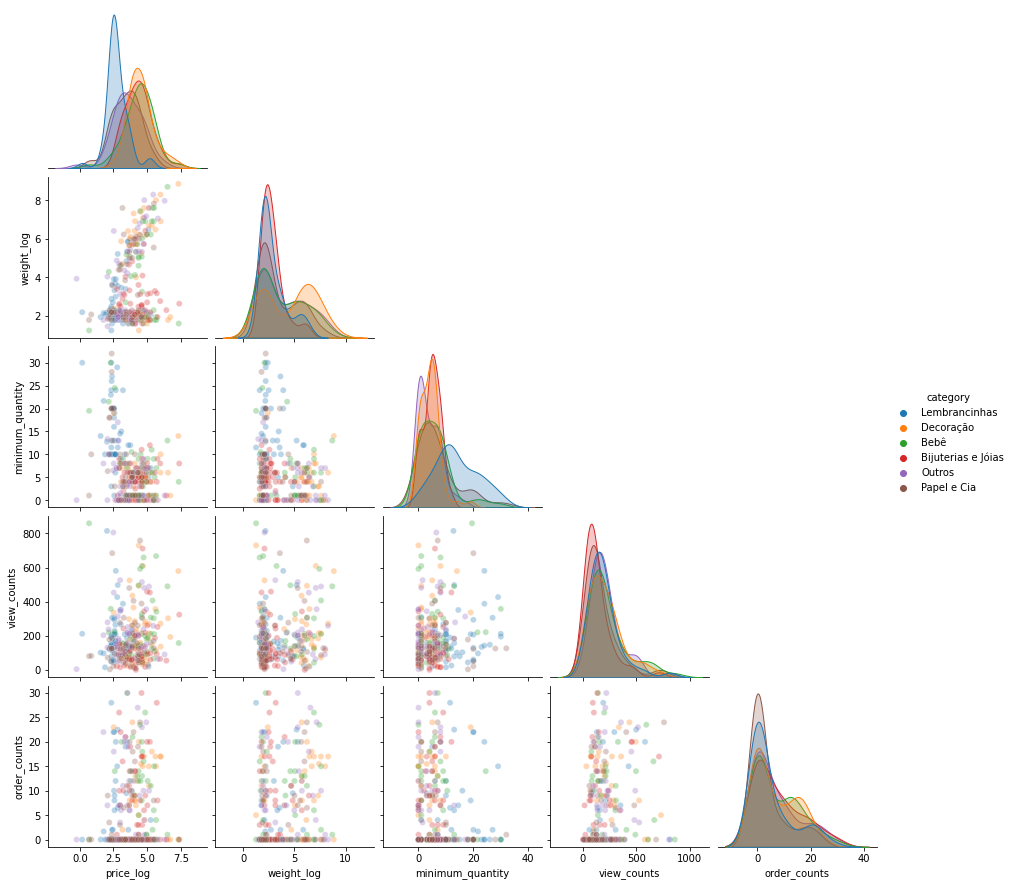

In [8]:
plot(df, col_list=col_list, stratify="category", size=50)

Pela análise gráfica, não foi possível identificar padrões claros que segmentem
os dados entre as categorias. Ainda assim, mesmo que não sejam suficientes,
alguns padrões podem ajudar a fazer a classificação:
- log do preço e o log do peso possuem correlação linear positiva para um
subconjunto de dados (mais para alguns itens de decoração e bebê)
- existe diferenças entre as tendências centrais dos preços das categorias.
Sendo as lembracinhas de menor valor e os de bebê os de maior valor.
- existe diferenças também quanto às distribuições dos pesos, onde os itens de
decoração apresentam os maiores pesos
- lembrancinhas em geral tendem a ter uma quantidade mínima maior.


Esse é um resultado até esperado. As cateogrias dos produtos devem refletir
o conteúdo, do produto, seus aspectos qualitativos. É claro que alguns tipos
de produtos tendem a ser mais caros, pesados ou comprados em maior quantidades
que outros, porém é necessário extrair características qualitativas dos
produtos. Uma forma de se fazer é indentificar tópicos associados aos títulos
e às tags dos produtos.

Para tal vamos adotar modelagem não supervisionada de tópicos a esses dados
textuais. A modelagem empregada consiste em primeiro tokenizar os textos,
em seguida vetorizar a partir de um TF-IDF e por fim aplicar a técnica NMF
de redução de dimensionalidade.

In [9]:
def analyze_low_freq_tokens(tokens_freq: pd.Series) -> None:
    tokens_freq_total = tokens_freq.sum()
    n_tokens = tokens_freq.shape[0]
    result_list = list()
    for min_freq in range(1, 11):
        min_freq_mask = tokens_freq <= min_freq
        n_tokens_select = min_freq_mask.sum()
        tokens_freq_select = tokens_freq[min_freq_mask].sum()
        tokens_sample = (tokens_freq[tokens_freq == min_freq].
                        sample(5).index.tolist())
        
        result = {"min_freq": min_freq,
                "n_tokens_share": n_tokens_select / n_tokens,
                "tokens_freq_share": tokens_freq_select / tokens_freq_total,
                "token_sample": tokens_sample}
        result_list.append(result)
    
    min_freq_result = pd.DataFrame(result_list).set_index("min_freq")
    display(min_freq_result)
    (min_freq_result[["n_tokens_share", "tokens_freq_share"]].
     plot(subplots=True, figsize=(10.8, 5),
          title="Parcela da quantidade e frequência dos tokens por frequência mínima"))
    plt.show()

In [10]:
def analyze_high_freq_tokens_by_category(tokens: pd.Series,
                                         categories: pd.Series) -> None:
      category_top_tokens = (tokens.to_frame("token").
                              join(categories).
                              groupby(categories.name).
                              apply(lambda x:
                                    x["token"].
                                    value_counts(normalize=True,
                                                 ascending=True).
                                    tail(15)).
                              reset_index())

      category_top_tokens.columns = ["category", "token", "category_share"]
      g = sns.FacetGrid(category_top_tokens, col="category",
                        col_wrap=3, height=4, sharey=False)
      g.map(plt.barh,"token",  "category_share")
      g.fig.subplots_adjust(top=0.9)
      g.fig.suptitle("Frequência dos top tokens por categoria")
      plt.show()

In [11]:
def tokens_analysis(docs: pd.Series, categories: pd.Series) -> None:
    tokens = docs.str.split().explode()
    tokens_freq = tokens.value_counts()
    analyze_low_freq_tokens(tokens_freq=tokens_freq)
    analyze_high_freq_tokens_by_category(tokens, categories)

- avaliar os tokens gerados - problemas com tokens pouco frequentes
- avaliar os tokens muito frequentes
- TF-IDF vectorizer


In [12]:
# https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
def remove_accents(text: str) -> str:
    
    nfkd_form = unicodedata.normalize("NFKD", text)
    ascii_form = nfkd_form.encode("ASCII", "ignore").decode()
    return ascii_form

In [13]:
stopwords = nltk.corpus.stopwords.words("portuguese")
stopwords = [remove_accents(word) for word in stopwords]

stemmer = nltk.stem.RSLPStemmer()

def custom_tokenizer(text: str) -> list[str]:
    token_list = nltk.tokenize.word_tokenize(text=text, language="portuguese")
    stem_list = [stemmer.stem(token)
                 for token in token_list
                 if token not in stopwords and len(token) > 2]
    
    return [remove_accents(stem) for stem in stem_list]

In [14]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)

    return text

In [15]:
def show_top_words(topic_model, tfidf_vec, n_words=10):
    for i, component in enumerate(topic_model.components_):
        top_words_ids = list(component.argsort()[:-n_words - 1: -1])
        top_words_list = tfidf_vec.get_feature_names_out()[top_words_ids]
        print(f"Topic {i} - {' | '.join(top_words_list)}")


def explore_topics(doc, by, n_components):
    tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer,
                                preprocessor=clean_text)
    tfidf_data = tfidf_vec.fit_transform(doc)
    topic_model = NMF(n_components=n_components, init="random")
    topic_data = topic_model.fit_transform(tfidf_data)
    show_top_words(topic_model=topic_model, tfidf_vec=tfidf_vec)
    
    topics_df = pd.DataFrame(topic_data, index=doc.index).join(by)
    topics_df.boxplot(column=list(range(n_components)),
                      by=by.name,
                      showfliers=False,
                      figsize=(15, 10))
    plt.show()

Topic 0 - dia | pal | canec | pres | profes | caix | chav | fot | pai | chinel
Topic 1 - matern | port | said | bols | menin | saqu | lembranc | enfeit | pec | urs
Topic 2 - lembranc | batiz | cas | ano | cha | padr | caix | aniversari | nasc | aromatiz
Topic 3 - person | canec | cop | sacol | canet | almof | necessa | lat | chav | acril
Topic 4 - kit | bebe | higien | croch | cha | decor | quadr | pec | menin | berc


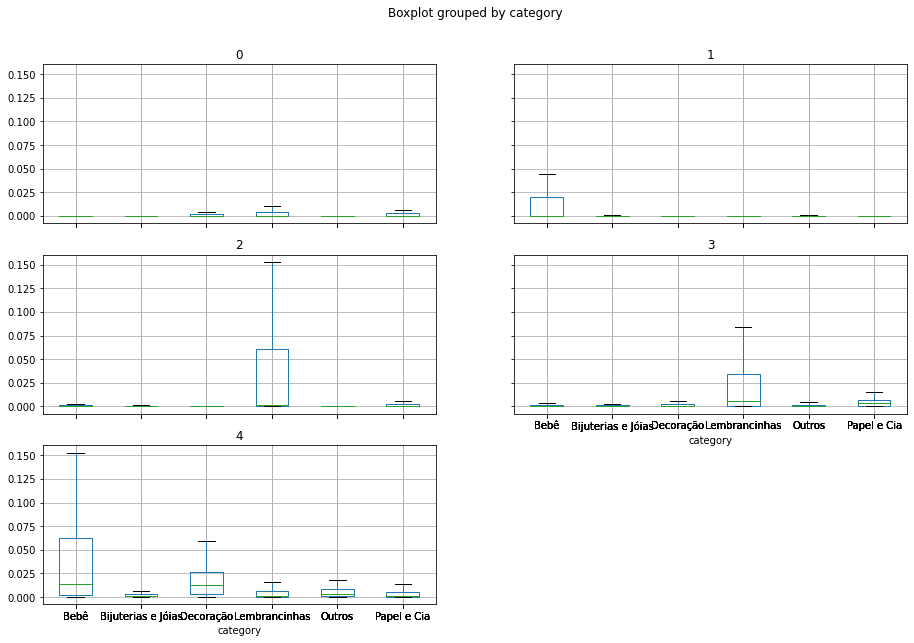

In [16]:
explore_topics(df["title"], df["category"], 5)

Topic 0 - dia | pal | profes | canec | mae | namor | pres | chinel | sandal | espec
Topic 1 - cas | tapet | decoraca | quadr | croch | papel | pared | decor | ades | quart
Topic 2 - beb | matern | cha | kit | menin | said | bols | port | higien | baby
Topic 3 - lembranc | batiz | aniversari | fest | matern | cas | ano | nasc | cha | padr
Topic 4 - person | canec | cop | fest | ano | sacol | canet | almof | aniversari | kit


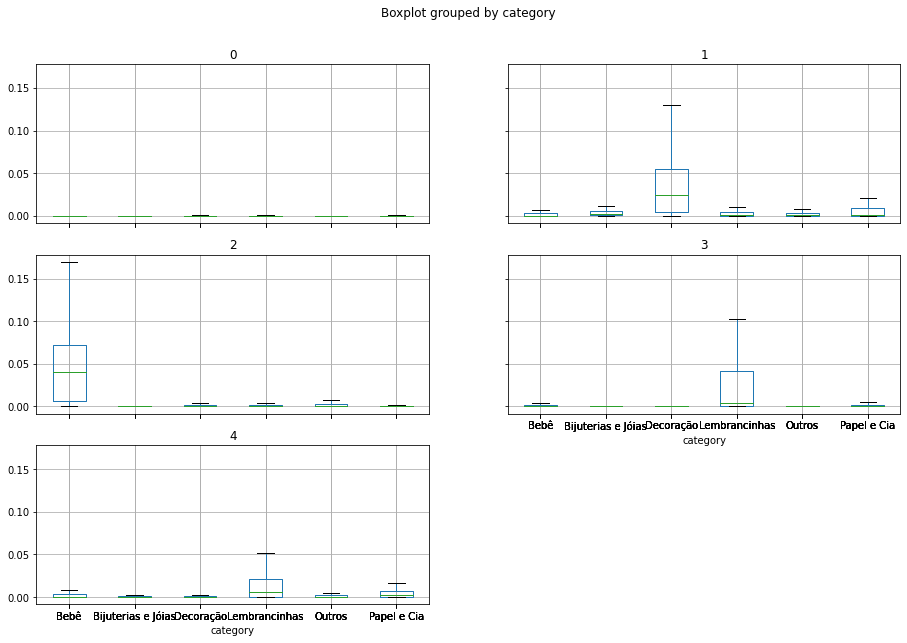

In [17]:
explore_topics(df["concatenated_tags"], df["category"], 5)